<a href="https://colab.research.google.com/github/AlecVOV/COS30018_OptionB_Group4/blob/main/COS30018_Intelligent_Systems_Colab_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetching Dataset

In [ ]:
import yfinance as yf

# Create ticker object
ticker = yf.Ticker("CBA.AX")

# Get historical data
data = ticker.history(period="10y")

# Print the dataframe
print(data)

# Save to CSV
data.to_csv("cba_stock_data.csv")

# Get current price using `.fast_info` (safer than `.info`)
print("Current Price:", ticker.fast_info['last_price'])

                                 Open        High         Low       Close  \
Date                                                                        
2015-06-01 00:00:00+10:00   53.360018   53.460652   52.548672   53.133595   
2015-06-02 00:00:00+10:00   53.536138   53.536138   52.202763   52.202763   
2015-06-03 00:00:00+10:00   51.888282   51.995207   51.297074   51.303360   
2015-06-04 00:00:00+10:00   51.259347   51.882006   50.611527   50.655556   
2015-06-05 00:00:00+10:00   50.554912   50.825359   50.183831   50.498306   
...                               ...         ...         ...         ...   
2025-05-26 00:00:00+10:00  173.500000  174.119995  172.649994  173.880005   
2025-05-27 00:00:00+10:00  174.399994  175.500000  173.380005  175.339996   
2025-05-28 00:00:00+10:00  175.940002  176.639999  173.789993  173.789993   
2025-05-29 00:00:00+10:00  174.490005  175.270004  172.565002  174.440002   
2025-05-30 00:00:00+10:00  174.250000  176.460007  173.960007  175.949997   

# Preprocessing Step

In [ ]:
import pandas as pd

# --- 1. Load Data ---
try:
    # Corrected file path for loading
    df_cba = pd.read_csv("cba_stock_data.csv")
    print("Successfully loaded cba_stock_data.csv")
    print("\nOriginal DataFrame head:")
    print(df_cba.head())
    print("\nOriginal DataFrame info:")
    df_cba.info()
except FileNotFoundError:
    print("Error: The file 'cba_stock_data.csv' was not found. Please ensure it is uploaded correctly.")
    exit() # Exit if file not found
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()

# --- 2. Date Handling ---
# Convert 'Date' column to datetime objects and standardize to UTC
try:
    df_cba['Date'] = pd.to_datetime(df_cba['Date'], utc=True)
    print("\n'Date' column converted to datetime (UTC).")
except Exception as e:
    print(f"Error converting 'Date' column to datetime: {e}")
    exit()

# Set 'Date' (UTC) column as the DataFrame index
df_cba.set_index('Date', inplace=True)
print("\n'Date' (UTC) column set as index.")
print(f"Index type: {type(df_cba.index)}")
print(f"Index dtype: {df_cba.index.dtype}")

# --- 3. Stock Splits Check ---
if 'Stock Splits' in df_cba.columns:
    if df_cba['Stock Splits'].sum() == 0:
        print("\nStock Splits column checked: No stock splits found requiring price adjustment.")
    else:
        print("\nStock Splits column checked: Stock splits found. Price adjustment might be needed but is not performed in this script.")
else:
    print("\n'Stock Splits' column not found.")

# --- 4. Feature Engineering ---
print("\nStarting feature engineering...")
# a. Date-based features
df_cba['Year'] = df_cba.index.year
df_cba['Month'] = df_cba.index.month
df_cba['Day'] = df_cba.index.day
df_cba['DayOfWeek'] = df_cba.index.dayofweek  # Monday=0, Sunday=6
df_cba['DayOfYear'] = df_cba.index.dayofyear
df_cba['WeekOfYear'] = df_cba.index.isocalendar().week.astype(int)
df_cba['Quarter'] = df_cba.index.quarter
print("- Date-based features created.")

# b. Lagged features
df_cba['Prev_Close'] = df_cba['Close'].shift(1)
df_cba['Prev_Volume'] = df_cba['Volume'].shift(1)
print("- Lagged features (Prev_Close, Prev_Volume) created.")

# c. Moving Averages (MA)
windows = [7, 14, 30]
for window in windows:
    df_cba[f'MA_Close_{window}D'] = df_cba['Close'].rolling(window=window).mean()
    df_cba[f'MA_Volume_{window}D'] = df_cba['Volume'].rolling(window=window).mean()
print(f"- Moving averages for Close and Volume (windows: {windows}) created.")

# d. Price Change/Return
df_cba['Daily_Return_Pct'] = df_cba['Close'].pct_change()
df_cba['Daily_Price_Change'] = df_cba['Close'].diff()
print("- Price change/return features (Daily_Return_Pct, Daily_Price_Change) created.")

# e. Price Range
df_cba['Price_Range_HL'] = df_cba['High'] - df_cba['Low']
df_cba['Price_Range_OC'] = df_cba['Open'] - df_cba['Close'] # Note: This can be negative
print("- Price range features (Price_Range_HL, Price_Range_OC) created.")

# f. Volatility
df_cba['Volatility_7D_Return'] = df_cba['Daily_Return_Pct'].rolling(window=7).std()
df_cba['Volatility_30D_Return'] = df_cba['Daily_Return_Pct'].rolling(window=30).std()
print("- Volatility features (7D and 30D rolling std dev of daily returns) created.")

# --- 5. Handling Missing Values ---
initial_rows = len(df_cba)
df_cba.dropna(inplace=True)
final_rows = len(df_cba)
print(f"\nMissing values handled by dropping rows. Original rows: {initial_rows}, Final rows: {final_rows}. Dropped: {initial_rows - final_rows}.")

# --- 6. Saved Preprocessed Data ---
output_filename = "cba_stock_data_preprocessed.csv"
try:
    df_cba.to_csv(output_filename)
    print(f"\nPreprocessed data saved to '{output_filename}'.")
    print("\nFinal preprocessed DataFrame head:")
    print(df_cba.head())
    print("\nFinal preprocessed DataFrame info:")
    df_cba.info()
except Exception as e:
    print(f"Error saving preprocessed data to CSV: {e}")

print("\n--- Preprocessing Complete ---")
print("The script has performed all requested preprocessing steps.")
print("\n--- Further Steps for ML Model Building (Recap) ---")
print("1. Define Target Variable (Y).")
print("2. Feature Selection.")
print("3. Data Scaling/Normalization.")
print("4. Train-Test Split (Chronological).")
print("5. Model Selection, Training, Evaluation, and Tuning.")
print("6. Address Stationarity & Leakage if necessary.")

Successfully loaded cba_stock_data.csv

Original DataFrame head:
                        Date       Open       High        Low      Close  \
0  2015-06-01 00:00:00+10:00  53.360029  53.460664  52.548684  53.133606   
1  2015-06-02 00:00:00+10:00  53.536138  53.536138  52.202763  52.202763   
2  2015-06-03 00:00:00+10:00  51.888294  51.995219  51.297085  51.303371   
3  2015-06-04 00:00:00+10:00  51.259339  51.881998  50.611520  50.655548   
4  2015-06-05 00:00:00+10:00  50.554904  50.825351  50.183823  50.498299   

    Volume  Dividends  Stock Splits  
0  2115325        0.0           0.0  
1  2626561        0.0           0.0  
2  3746197        0.0           0.0  
3  3795236        0.0           0.0  
4  2906801        0.0           0.0  

Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2532 non-null

# EDA Process

Successfully loaded 'cba_stock_data_preprocessed.csv'.

Preprocessed DataFrame head for EDA:
                                Open       High        Low      Close  \
Date                                                                    
2015-07-13 14:00:00+00:00  54.353758  54.548731  53.907203  54.246838   
2015-07-14 14:00:00+00:00  54.341180  54.907233  54.341180  54.794022   
2015-07-15 14:00:00+00:00  55.347505  55.605375  55.095922  55.322346   
2015-07-16 14:00:00+00:00  55.529904  55.567641  54.982719  55.334927   
2015-07-19 14:00:00+00:00  55.347518  55.611674  55.171409  55.573936   

                            Volume  Dividends  Stock Splits  Year  Month  Day  \
Date                                                                            
2015-07-13 14:00:00+00:00  2382827        0.0           0.0  2015      7   13   
2015-07-14 14:00:00+00:00  2491791        0.0           0.0  2015      7   14   
2015-07-15 14:00:00+00:00  2208707        0.0           0.0  2015      

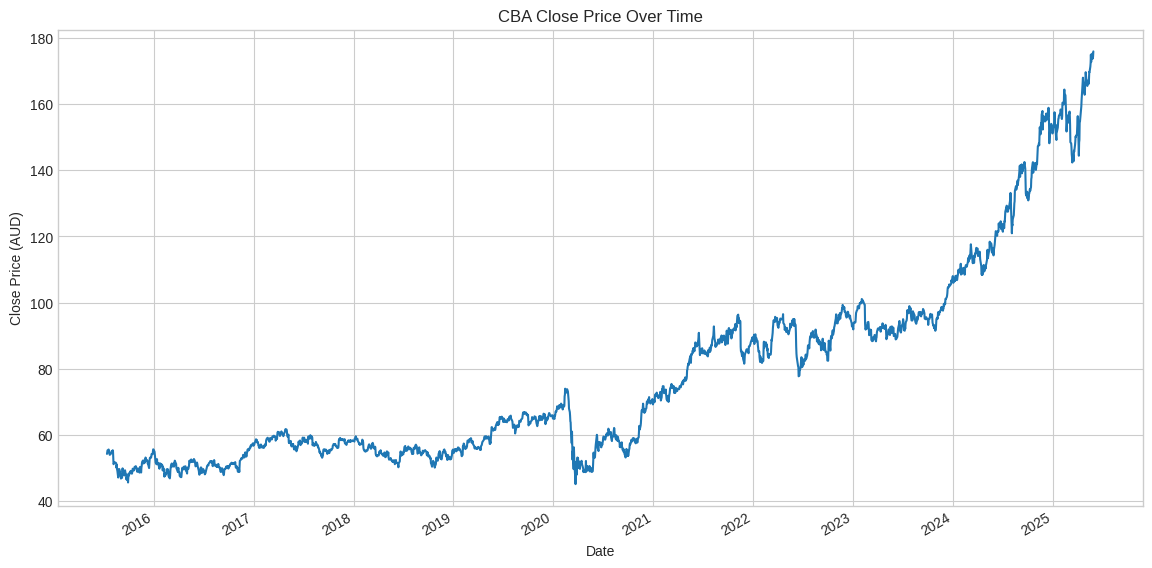

Saved cba_close_price_over_time.png


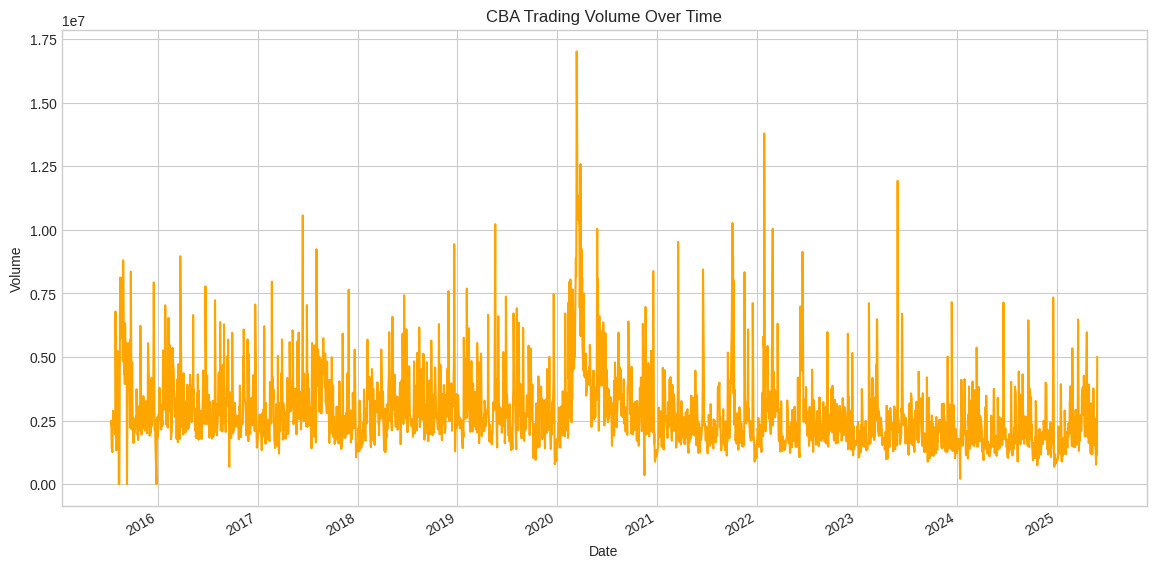

Saved cba_volume_over_time.png


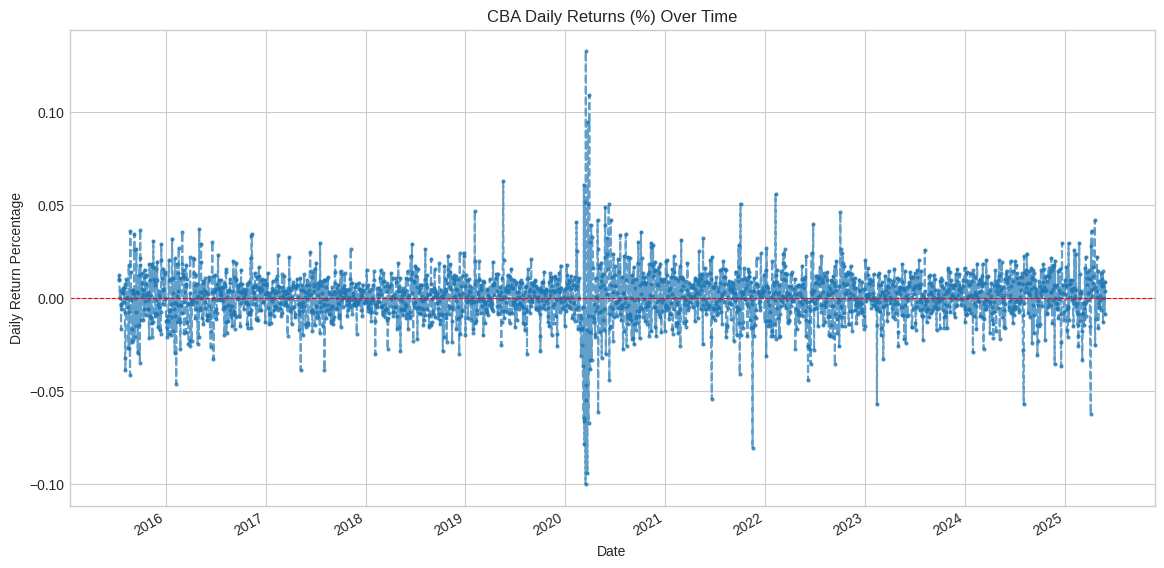

Saved cba_daily_returns_over_time.png


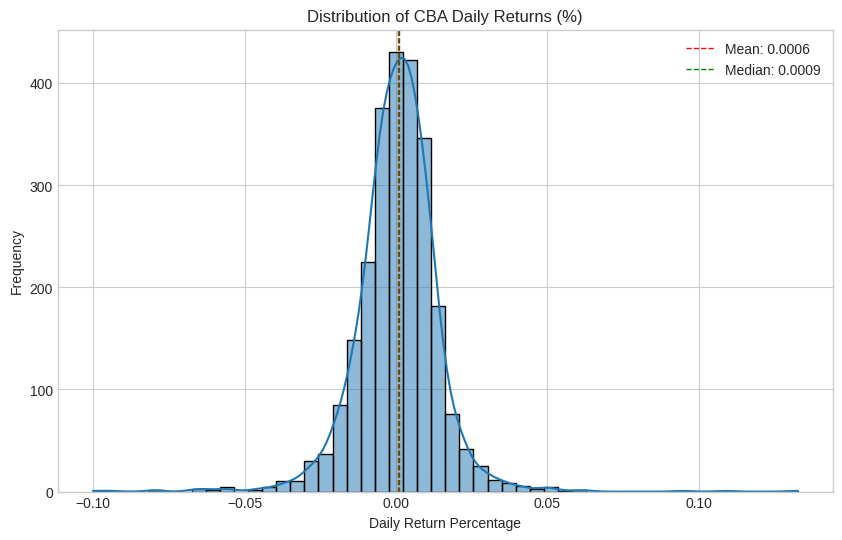

Saved cba_daily_returns_histogram.png


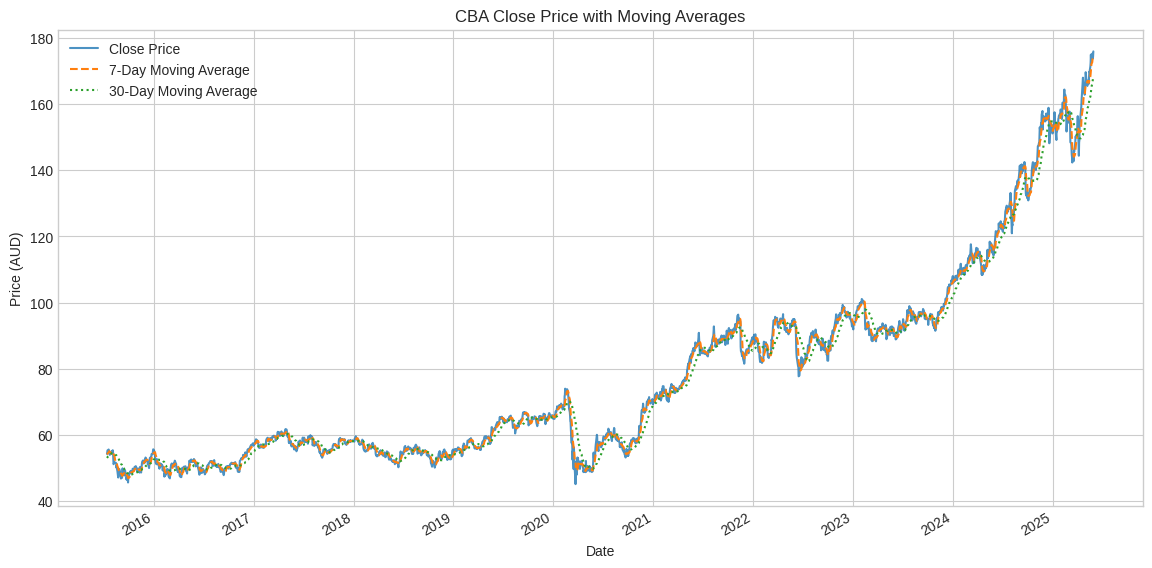

Saved cba_close_price_with_ma.png


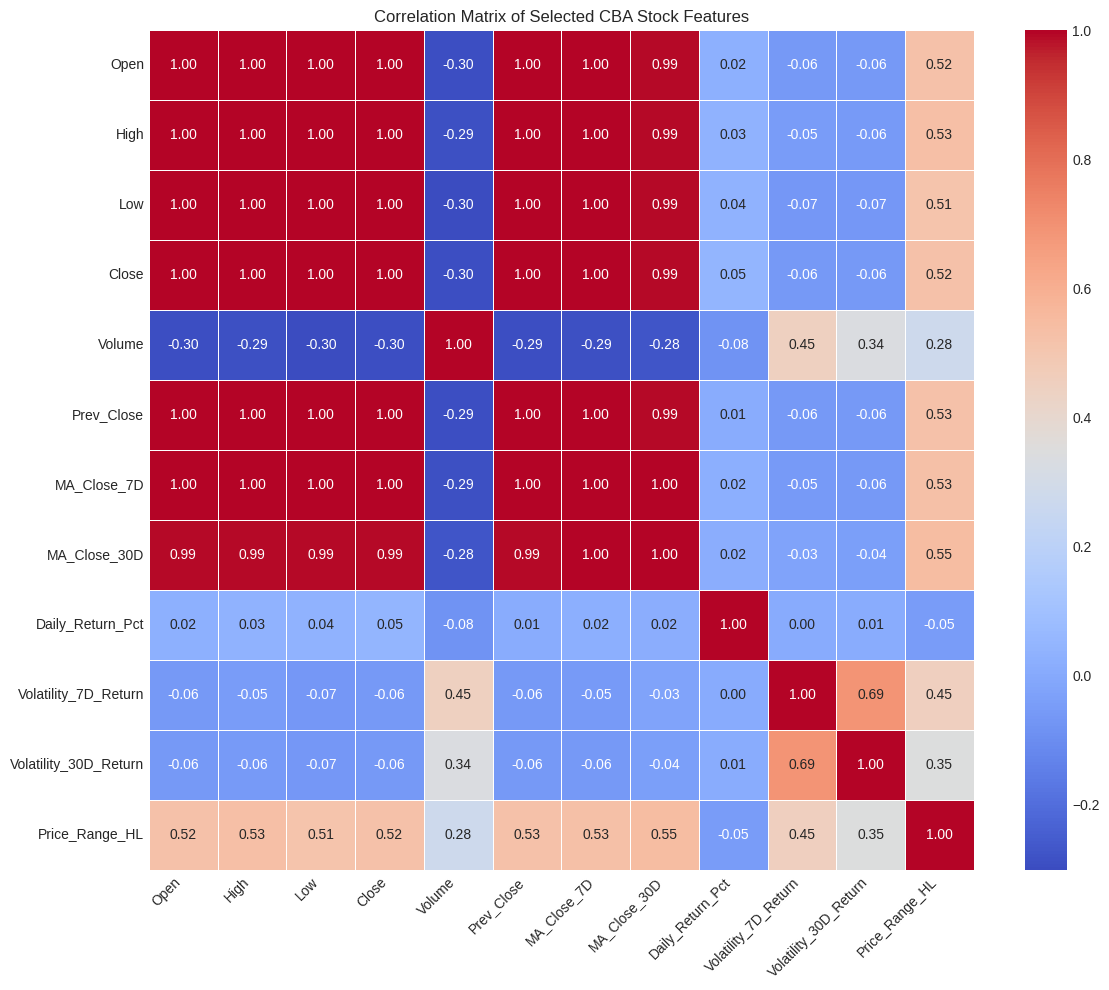

Saved cba_correlation_heatmap.png


<ipython-input-3-a22c2e7302db>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_eda.index.year, y='Daily_Return_Pct', data=df_eda, palette='viridis')


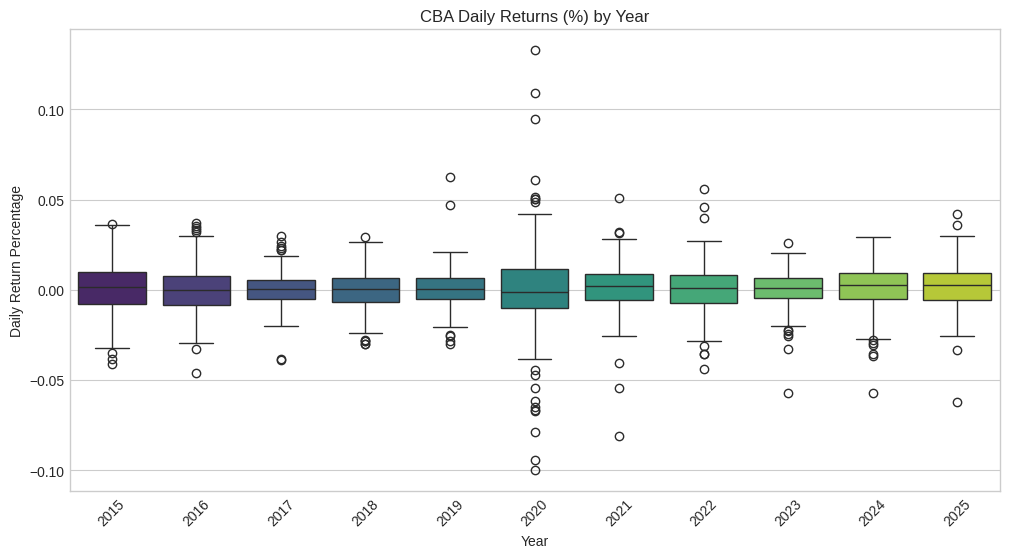

Saved cba_daily_returns_boxplot_year.png


<ipython-input-3-a22c2e7302db>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_eda.index.month, y='Daily_Return_Pct', data=df_eda, palette='Spectral')


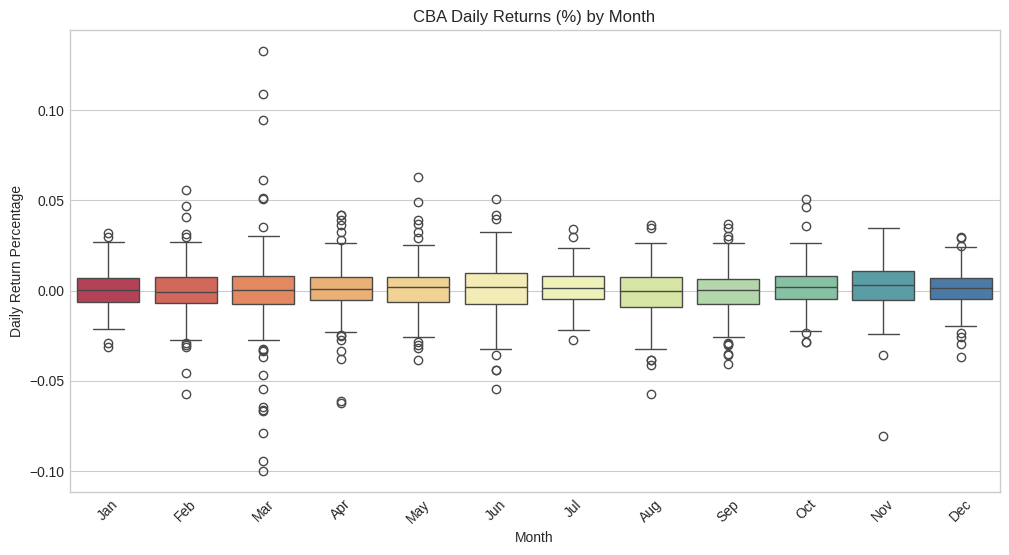

Saved cba_daily_returns_boxplot_month.png


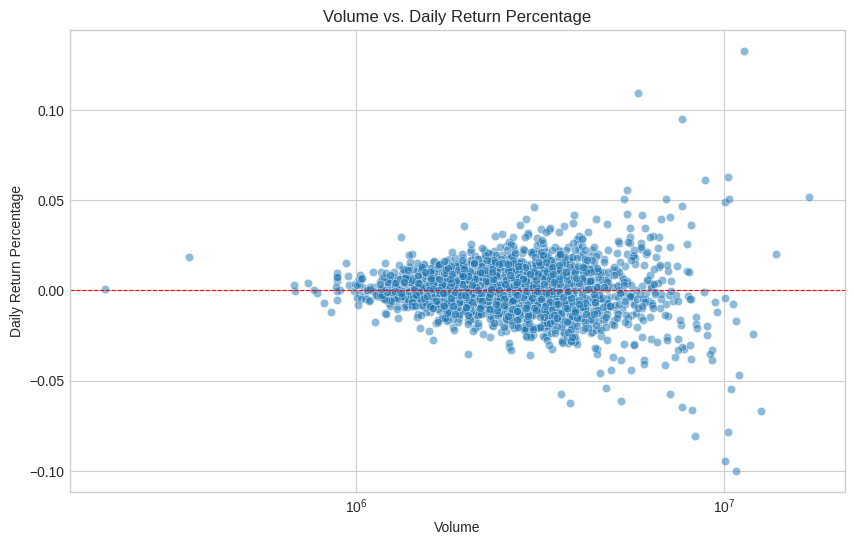

Saved cba_volume_vs_daily_return.png


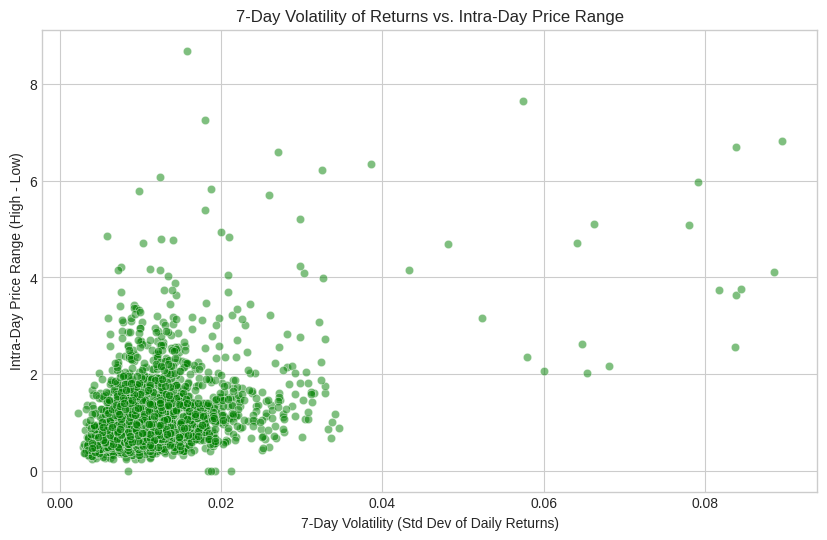

Saved cba_volatility_vs_price_range.png

--- EDA Visualizations Generated and Saved ---
Plots include time series, distributions, correlations, and box plots.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Preprocessed Data ---
# It's good practice to reload the data to ensure this cell is runnable independently
# and uses the correctly preprocessed data.
try:
    df_eda = pd.read_csv("cba_stock_data_preprocessed.csv", index_col='Date', parse_dates=True)
    print("Successfully loaded 'cba_stock_data_preprocessed.csv'.")
    print("\nPreprocessed DataFrame head for EDA:")
    print(df_eda.head())
    print("\nPreprocessed DataFrame info for EDA:")
    df_eda.info()
except FileNotFoundError:
    print("Error: 'cba_stock_data_preprocessed.csv' not found. Please ensure the previous preprocessing step was successful and the file was saved.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the preprocessed data: {e}")
    exit()

# --- 2. Summary Statistics ---
print("\n--- Summary Statistics ---")
print(df_eda.describe())

# --- 3. Visualizations ---
print("\n--- Generating Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics

# a. Close Price Over Time
plt.figure(figsize=(14, 7))
df_eda['Close'].plot(title='CBA Close Price Over Time')
plt.ylabel('Close Price (AUD)')
plt.xlabel('Date')
plt.savefig("cba_close_price_over_time.png")
plt.show()
print("Saved cba_close_price_over_time.png")

# b. Volume Over Time
plt.figure(figsize=(14, 7))
df_eda['Volume'].plot(title='CBA Trading Volume Over Time', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.savefig("cba_volume_over_time.png")
plt.show()
print("Saved cba_volume_over_time.png")

# c. Daily Returns Over Time
plt.figure(figsize=(14, 7))
df_eda['Daily_Return_Pct'].plot(title='CBA Daily Returns (%) Over Time', linestyle='--', marker='o', markersize=2, alpha=0.7)
plt.ylabel('Daily Return Percentage')
plt.xlabel('Date')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Line at 0 for reference
plt.savefig("cba_daily_returns_over_time.png")
plt.show()
print("Saved cba_daily_returns_over_time.png")

# d. Histogram of Daily Returns
plt.figure(figsize=(10, 6))
sns.histplot(df_eda['Daily_Return_Pct'], kde=True, bins=50)
plt.title('Distribution of CBA Daily Returns (%)')
plt.xlabel('Daily Return Percentage')
plt.ylabel('Frequency')
plt.axvline(df_eda['Daily_Return_Pct'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {df_eda['Daily_Return_Pct'].mean():.4f}")
plt.axvline(df_eda['Daily_Return_Pct'].median(), color='green', linestyle='dashed', linewidth=1, label=f"Median: {df_eda['Daily_Return_Pct'].median():.4f}")
plt.legend()
plt.savefig("cba_daily_returns_histogram.png")
plt.show()
print("Saved cba_daily_returns_histogram.png")

# e. Close Price with Moving Averages (7D and 30D)
plt.figure(figsize=(14, 7))
df_eda['Close'].plot(label='Close Price', alpha=0.8)
df_eda['MA_Close_7D'].plot(label='7-Day Moving Average', linestyle='--')
df_eda['MA_Close_30D'].plot(label='30-Day Moving Average', linestyle=':')
plt.title('CBA Close Price with Moving Averages')
plt.ylabel('Price (AUD)')
plt.xlabel('Date')
plt.legend()
plt.savefig("cba_close_price_with_ma.png")
plt.show()
print("Saved cba_close_price_with_ma.png")

# f. Correlation Matrix/Heatmap (Selecting a subset of numerical features for clarity)
# Let's select key original and engineered features that are likely to be interesting
features_for_corr = ['Open', 'High', 'Low', 'Close', 'Volume', 'Prev_Close',
                     'MA_Close_7D', 'MA_Close_30D', 'Daily_Return_Pct',
                     'Volatility_7D_Return', 'Volatility_30D_Return', 'Price_Range_HL']
subset_df_for_corr = df_eda[features_for_corr]
correlation_matrix = subset_df_for_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected CBA Stock Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig("cba_correlation_heatmap.png")
plt.show()
print("Saved cba_correlation_heatmap.png")

# g. Box Plot of Daily Returns by Year
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_eda.index.year, y='Daily_Return_Pct', data=df_eda, palette='viridis')
plt.title('CBA Daily Returns (%) by Year')
plt.xlabel('Year')
plt.ylabel('Daily Return Percentage')
plt.xticks(rotation=45)
plt.savefig("cba_daily_returns_boxplot_year.png")
plt.show()
print("Saved cba_daily_returns_boxplot_year.png")

# h. Box Plot of Daily Returns by Month
plt.figure(figsize=(12, 6))
# Month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(x=df_eda.index.month, y='Daily_Return_Pct', data=df_eda, palette='Spectral')
plt.title('CBA Daily Returns (%) by Month')
plt.xlabel('Month')
plt.ylabel('Daily Return Percentage')
plt.xticks(ticks=range(12), labels=month_names, rotation=45) # Map month numbers to names
plt.savefig("cba_daily_returns_boxplot_month.png")
plt.show()
print("Saved cba_daily_returns_boxplot_month.png")


# i. Scatter plot: Volume vs. Daily Return Percentage
plt.figure(figsize=(10, 6))
plt.scatter(df_eda['Volume'], df_eda['Daily_Return_Pct'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.title('Volume vs. Daily Return Percentage')
plt.xlabel('Volume')
plt.ylabel('Daily Return Percentage')
plt.xscale('log') # Volume often has a wide range, log scale can help
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.savefig("cba_volume_vs_daily_return.png")
plt.show()
print("Saved cba_volume_vs_daily_return.png")

# j. Scatter plot: Volatility (7D) vs. Price Range (High-Low)
plt.figure(figsize=(10, 6))
plt.scatter(df_eda['Volatility_7D_Return'], df_eda['Price_Range_HL'], alpha=0.5, edgecolors='w', linewidth=0.5, color='green')
plt.title('7-Day Volatility of Returns vs. Intra-Day Price Range')
plt.xlabel('7-Day Volatility (Std Dev of Daily Returns)')
plt.ylabel('Intra-Day Price Range (High - Low)')
plt.savefig("cba_volatility_vs_price_range.png")
plt.show()
print("Saved cba_volatility_vs_price_range.png")


print("\n--- EDA Visualizations Generated and Saved ---")
print("Plots include time series, distributions, correlations, and box plots.")